
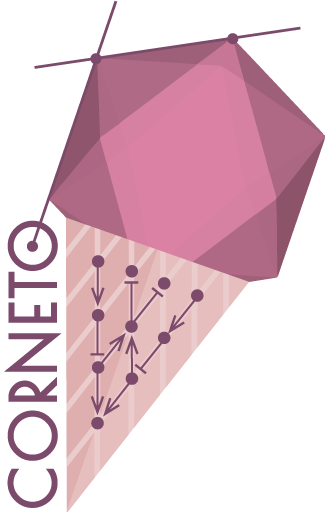

In [1]:
import corneto as cn
import numpy as np
import pandas as pd
from copy import deepcopy
import seaborn as sns

pal = sns.color_palette("muted")

cn.info()

In [2]:
sns.set_palette(pal)
solver = "GUROBI"
tol = 1e-6

In [3]:
G = cn.Graph.from_miom_model("https://github.com/pablormier/miom-gems/raw/refs/heads/main/gems/mitocore/v1.0.1/default.miom")
G.shape

(441, 555)

In [4]:
rxn_obj_id = next(G.get_edges_by_attr("id", "EX_biomass_e"))
rxn_obj_id

12

In [5]:
def corneto_fba(G, rxn_obj=None, min_flux=None, sparse=False):
    lb = np.array(G.get_attr_from_edges("default_lb"))
    ub = np.array(G.get_attr_from_edges("default_ub"))
    P = cn.opt.Flow(G, lb=lb, ub=ub, values=True, n_flows=1)
    F = P.expr.flow
    if sparse:
        P += cn.opt.Indicator(F)
        P.add_objectives(sum(P.expr._flow_i))
    if rxn_obj is not None:
        if isinstance(rxn_obj, str):
            rxn_obj = next(G.get_edges_by_attr("id", rxn_obj))
        if min_flux is not None:
            P += F[rxn_obj] >= min_flux
        P.add_objectives(-F[rxn_obj])
    return P

problem = corneto_fba(G, rxn_obj=rxn_obj_id)
problem.solve(solver=solver)
opt_flux = problem.expr.flow[rxn_obj_id].value
opt_flux

Set parameter Username
Set parameter LicenseID to value 2593994
Academic license - for non-commercial use only - expires 2025-12-02


100.89230387215572

In [6]:
len(np.flatnonzero(np.abs(problem.expr.flow.value)))

231

In [7]:
np.sum(np.abs(problem.expr.flow.value)>=1e-6)

231

In [8]:
problem = corneto_fba(G, rxn_obj=rxn_obj_id, min_flux=opt_flux, sparse=True)
problem.solve(solver=solver)
nrxns_min = np.sum(np.abs(problem.expr.flow.value)>=tol)
nrxns_min

216

In [9]:
import os

if os.path.isfile('mitocore.csv'):
    df_ko_result = pd.read_csv('mitocore.csv').set_index('i')
    ko_result = [(r.i, r.id, r.opt_flux, r.min_rxn) for (_, r) in df_ko_result.reset_index().iterrows()]
    ko_result
else:
    ko_result = []
    for i in range(net.R.shape[0]):
        nkoi = do_ko(net, i)
        pf = corneto_flow(nkoi, rxn_obj=rxn_obj_id)
        pf.solve(solver=solver, verbosity=0)
        opt_ko_flux = pf.symbols['_flow'][rxn_obj_id].value
        pf = corneto_flow(nkoi, rxn_obj=rxn_obj_id, min_flux=opt_ko_flux, sparse=True)
        pf.solve(solver=solver, verbosity=0)
        print(i, net.R['id'][i], opt_ko_flux, pf.objectives[0].value)
        ko_result.append((i, net.R['id'][i], opt_ko_flux, pf.objectives[0].value))

In [10]:
# Simulations on MitoCore performing single KOs. This is done to find
# the reactions that have some impact on biomass production, as candidates for
# the multi-condition simulation
ko_result

[(0, 'EX_2hb_e', 100.89230387215594, 207.00004384651027),
 (1, 'EX_ac_e', 100.89230387215562, 207.00004380812305),
 (2, 'EX_acac_e', 100.80501513081464, 204.00004381517303),
 (3, 'EX_akg_e', 100.89230387215564, 207.0000438261111),
 (4, 'EX_ala_B_e', 100.89230387215557, 207.00004384011083),
 (5, 'EX_ala_L_e', 100.87799359723672, 205.00004374560567),
 (6, 'EX_arg_L_e', 100.87501109771534, 204.00000586641528),
 (7, 'EX_argsuc_e', 100.89230387215562, 207.00004380846),
 (8, 'EX_asn_L_e', 100.87529089453396, 204.0000438372241),
 (9, 'EX_asp_L_e', 100.62629856007646, 204.0000533105055),
 (10, 'EX_bhb_e', 100.8344159682852, 203.0000438310217),
 (11, 'EX_bilirub_e', 100.89230387215562, 207.00004387512104),
 (12, 'EX_biomass_e', 0.0, 0.0),
 (13, 'EX_but_e', 100.89230387215554, 207.00004380825368),
 (14, 'EX_chol_e', 100.89230387215564, 207.0000438228255),
 (15, 'EX_cit_e', 100.89230387215564, 207.0000438520879),
 (16, 'EX_citr_L_e', 100.89230387215564, 207.00004380846),
 (17, 'EX_co_e', 100.8923

In [11]:
intervention_obj_effect = {k_id: flux for k_id, _, flux, _ in ko_result}

In [12]:
# Show some interesting interventions
subset_interventions = []
for k_id, r_id, opt_ko_flux, n_rxns in ko_result:
    if abs(n_rxns - nrxns_min) > 10 and opt_ko_flux > 1e-3 and opt_ko_flux <= 0.999*opt_flux:
        print(k_id, r_id, opt_ko_flux, n_rxns)
        subset_interventions.append(k_id)

9 EX_asp_L_e 100.62629856007646 204.0000533105055
18 EX_co2_e 12.916868239866858 181.00004599129625
26 EX_glc_D_e 97.40185979214648 201.00004388426865
31 EX_h_e 99.341099932917 190.00004187440737
32 EX_h2o_e 84.27054152662792 177.0000607741228
35 EX_hdca_e 49.91050423765515 272.0000708135958
39 EX_lac_L_e 100.35230090215278 204.0000438790995
47 EX_nh4_e 100.4794679320681 129.0000019452489
49 EX_o2_e 1.846509909909828 102.00003696679973
74 HEX1 97.40185979214648 201.00004388426865
76 PGI 97.84603900999088 237.0000563006875
80 TPI 97.43093092183904 201.00004736414124
81 GAPD 97.38249779574096 192.00004383995991
82 PGK 97.38249779574096 192.00004383995991
88 LDH_L 100.35230090215278 204.0000438790995
97 PDHm 98.4927588944543 194.0000768734728
98 CSm 6.581457531655777 186.00006398705256
99 ACONTm 99.0374844711101 198.00006285265715
100 ICDHxm 95.94602724560954 197.00005630237197
106 MDHm 27.885252871451897 185.0000511933078
107 CI_MitoCore 69.89555499412448 174.00004743747257
108 CII_MitoC

In [13]:
len(subset_interventions)

48

Find a network with some characteristics (e.g production of biomass) and the networks for each intervention. Assumption is that each alt. network after intervention has min. distance wrt the control network.

In [14]:
def singlesparse_fba(G, interventions, obj_rxn=rxn_obj_id, opt_ko=None, prop_opt_ko=1.0, verbose=True):
    models = []
    S = np.zeros((G.shape[1], len(interventions)))
    F = np.zeros((G.shape[1], len(interventions)))
    for i, kid in enumerate(interventions):
        opt_flux = 0
        if opt_ko is not None:
            print(i, kid, prop_opt_ko * opt_ko[kid])
            opt_flux = prop_opt_ko*opt_ko[kid]
        pf = corneto_fba(G, rxn_obj=rxn_obj_id, min_flux=opt_flux, sparse=True)
        pf += pf.expr._flow_i[kid] == 0
        pf += pf.expr.flow[kid] == 0
        pf.solve(solver=solver, verbosity=int(verbose))
        S[:, i] = (np.abs(pf.expr.flow.value) >= tol).astype(int)
        F[:, i] = pf.expr.flow.value
        models.append(pf)
    return S, F

In [15]:
def multisparse_fba(G, interventions, obj_rxn=rxn_obj_id, alpha=1e-2, 
                    multi=True, opt_ko=None, prop_opt_ko=1.0, use_and=False, 
                    verbose=True, norel=0, time_limit=400, smodels=None, gap=0, min_or=False):
    # Maximize fba per intervention minimizing the distance across networks
    conditions = len(interventions)
    lb = np.array(G.get_attr_from_edges("default_lb"))
    ub = np.array(G.get_attr_from_edges("default_ub"))
    P = cn.opt.Flow(G, lb=lb, ub=ub, values=True, n_flows=conditions)
    P += cn.opt.Indicator(P.expr.flow)
    selected = []
    for i in range(conditions):
        F = P.expr._flow[:, i]
        sel = P.expr._flow_i[:, i]
        intv = interventions[i]
        # maximize biomass (if no info about opt ko)
        if opt_ko is None:
            P.add_objectives(-F[obj_rxn])
        else:
            print(f"Intervention: {intv}, FBA sol = {opt_ko[intv]}, FBA sol {prop_opt_ko*100}% = {prop_opt_ko * opt_ko[intv]}")
            #print(intv, prop_opt_ko * opt_ko[intv])
            P += F[obj_rxn] >= prop_opt_ko * opt_ko[intv]
        # Block flux on intervened reaction
        P += sel[intv] == 0 # blocked
        P += F[intv] == 0
        selected.append(sel)
        if not multi:
            P.add_objectives(sum(sel), weights=alpha)
    if alpha > 0:
        total = sum(selected)
        if min_or:
            # Old implementation
            logic_or = cn.K.Variable(name='_or', shape=total.shape, vartype=cn.VarType.BINARY)
            P += [
                # only 0 if total is 0
                logic_or >= total/conditions,
                logic_or <= total
            ]
            P.add_objectives(sum(logic_or), weights=alpha)
        else:
            P += cn.opt.linear_or(P.expr._flow_i, axis=1, varname="Y")
            P.add_objectives(sum(P.expr.Y), weights=alpha)
    warm_start = smodels != None    
    opt = {
        'IntegralityFocus': 1,
        'NoRelHeurTime': norel
    }
    if gap > 0:
        opt['MIPGap'] = gap
    P.solve(solver='GUROBI', verbosity=int(verbose), TimeLimit=time_limit, 
            warm_start=warm_start, **opt)
    return P, selected


## Experiments

Sparse FBA tries to find the smallest flux consistent metabolic network that is able to attain a particular objective. For multiple conditions, taking the union of one sparse FBA per condition do not achieve optimal results. Here we show how multi-condition sparse FBA can find better networks by integrating information from multiple conditions.

We show this first for a given set of interventions, assuming we know the optimal possible FBA solution per KO.

In [16]:
np.random.seed(42)
prop_opt_ko = 0.95
norel=60
norel=0
timelimit=300
verbose=False
reps=10
sizes = [2, 4, 8, 16]

# Generate experiments
experiments = []
for size in sizes:
    for i in range(reps):
        sel_ids = np.random.choice(subset_interventions, size, replace=False)
        experiments.append((size, i, sel_ids))

df_experiments = pd.DataFrame(experiments, columns=["size", "rep", "intv_ids"])
df_experiments

,size,rep,intv_ids
0,2,0,"[171, 483]"
1,2,1,"[485, 109]"
2,2,2,"[81, 485]"
3,2,3,"[482, 82]"
4,2,4,"[81, 97]"
5,2,5,"[440, 108]"
6,2,6,"[535, 74]"
7,2,7,"[170, 535]"
8,2,8,"[483, 440]"
9,2,9,"[35, 486]"


In [17]:
def run_experiments(experiments, prop_opt_ko=prop_opt_ko, alpha=1.0, min_or=False):
    results = []
    for i, r in experiments.iterrows():
        sel_ids = r.intv_ids
        print(f"k={r.size} (row {i}), selected interventions: {sel_ids}")
        print("- Running single...")
        Ns, Fs = singlesparse_fba(G, sel_ids, opt_ko=intervention_obj_effect, prop_opt_ko=prop_opt_ko, verbose=False)
        rxn_single = sum(np.sum(Ns, axis=1) > 0)
        print("- Running multi...")
        Mm = multisparse_fba(G, sel_ids, alpha=alpha, multi=True, verbose=verbose, norel=norel, min_or=min_or,
                             time_limit=timelimit, opt_ko=intervention_obj_effect, prop_opt_ko=prop_opt_ko)
        Nm = (np.abs(Mm[0].expr.flow.value) >= tol).astype(int)
        Fm = Mm[0].expr.flow.value
        rxn_multi = sum(np.mean(Nm, axis=1) > 0)
        results.append((i, Ns, Fs, Nm, Fm, rxn_single, rxn_multi))
        print(f"N. conditions = {size}, Inferred network size: single={rxn_single}, multi={rxn_multi}")
    return results

In [18]:
def get_df_results(df_experiments, results):
    r_values = []
    for (i, r), res in zip(df_experiments.iterrows(), results):
        r_values.append((len(r.intv_ids), r.rep, res[-1], res[-2]))
    df = pd.DataFrame(r_values, columns=['size_interv', 'rep', 'multi', 'single'])
    return df

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

def boxplots(df, ax=None, palette=None):
    df_long = df.drop('rep', axis=1).melt(id_vars='size_interv', var_name='method', value_name='value')
    g = sns.boxplot(x="size_interv", y="value", hue="method", palette=palette, data=df_long, ax=ax)
    g.set_xlabel("Number of conditions (condition = single KO on an enzyme)")
    g.set_ylabel("N. of unique reactions")
    return g

#boxplots(df)
# Customize the title
#plt.title(f"A) Size of inferred network with multi-condition vs union of independent Sparse FBA (flux opt. {round(prop_opt_ko*100)}%)") 
#plt.savefig(f"boxplots-{prop_opt_ko}.pdf", bbox_inches='tight');

In [20]:
def calc_props(results):
    selected_single = []
    selected_multi = []
    for r in results:
        _, result_single, _, result_multi, _, _, _ = r
        selected_multi.append(result_multi)
        selected_single.append(result_single)
    prop_rxn_single = np.concatenate(selected_single, axis=1).mean(axis=1)
    prop_rxn_multi = np.concatenate(selected_multi, axis=1).mean(axis=1)
    df_proportions = pd.DataFrame(
        {'rxn': G.get_attr_from_edges("id"), 'rxn_prop_single': prop_rxn_single, 'rxn_prop_multi': prop_rxn_multi}
    ).set_index("rxn").sort_values(by="rxn_prop_multi", ascending=False)
    return df_proportions


In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_rxn_proportions(df_proportions, n=50, ax=None):
    ix_rxn = df_proportions.std(axis=1).sort_values(ascending=False).head(n).index
    df_top_proportions = df_proportions.loc[ix_rxn].sort_values(by="rxn_prop_multi", ascending=False)
    df_top_proportions.columns=['single sFBA', 'multi sFBA']
    df_top_proportions = df_top_proportions[["multi sFBA", "single sFBA"]]
    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
        created_fig = True
        
    df_top_proportions.plot(kind='bar', stacked=False, ax=ax, color=pal)
    ax.set_xlabel('Reactions')
    ax.set_ylabel('Prop. of reactions')

    # Customizing x-axis labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90) # Rotate labels to vertical
    ax.tick_params(axis='x', labelsize=10) # Make labels smaller

    # Apply tight_layout if a new figure was created
    if created_fig:
        fig.tight_layout()

    return ax


def plot_rxn_proportions0(df_proportions, n=50, ax=None):
    ix_rxn = df_proportions.std(axis=1).sort_values(ascending=False).head(n).index
    df_top_proportions = df_proportions.loc[ix_rxn].sort_values(by="rxn_prop_multi", ascending=False)
    
    # Flag to track if we created a new figure
    created_fig = False

    # Check if ax is None, create plt and ax if needed
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
        created_fig = True

    # Plotting col1
    sns.barplot(
        x=df_top_proportions.index, 
        y=df_top_proportions['rxn_prop_single'],
        color='blue',
        alpha=0.5,
        label='single sFBA',
        ax=ax
    )

    # Plotting col2 overlapped
    sns.barplot(
        x=df_top_proportions.index,
        y=df_top_proportions['rxn_prop_multi'],
        color='red',
        alpha=0.5,
        label='multi sFBA',
        ax=ax
    )

    # Adding legend and other customizations
    ax.legend()
    #ax.set_title('Prop. of selected reactions across conditions, union of single vs multi Sparse FBA')
    ax.set_xlabel('Reactions')
    ax.set_ylabel('Prop. of reactions')

    # Customizing x-axis labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90) # Rotate labels to vertical
    ax.tick_params(axis='x', labelsize=10) # Make labels smaller

    # Apply tight_layout if a new figure was created
    if created_fig:
        fig.tight_layout()

    return ax

#plot_rxn_proportions(df_proportions);

In [22]:
def collect(experiments, results, fluxes=False):
    nets = []
    labels = []
    for (i, r), res in zip(experiments.iterrows(), results):
        sz = r['size']
        if not fluxes:
            N_single = res[1].astype(int)
            N_multi = res[3].astype(int)
        else:
            N_single = res[2]
            N_multi = res[4]
        nets.append(N_single)
        labels.extend([f"c{sz}_single"]*N_single.shape[1])
        nets.append(N_multi)
        labels.extend([f"c{sz}_multi"]*N_multi.shape[1])

    cnets = np.concatenate(nets, axis=1)
    return pd.DataFrame(cnets, index=net.R['id'], columns=labels)

In [23]:
def create_multifig(df_experiments, result, prop=1.0, n_top_rxn_prop=25, figsize=(20, 6), title=True, fontsize=20, axs=None):
    fig = None
    if axs is None:
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
    g = boxplots(get_df_results(df_experiments, result), ax=axs[0])
    df_proportions = calc_props(result)
    plot_rxn_proportions(df_proportions, ax=axs[1], n=n_top_rxn_prop);
    if title:
        axs[0].set_title(f"A) Size of inferred network\n (multi vs union of single sFBA) (flux opt. {round(prop_opt_ko*100)}%)", pad=20, fontsize=fontsize);
        axs[1].set_title("B) Proportion of selected reactions across conditions", pad=20, fontsize=fontsize)
    return fig, axs


In [24]:
prop_opt_ko=0.90
results_90 = run_experiments(df_experiments, prop_opt_ko=prop_opt_ko)

k=3 (row 0), selected interventions: [171 483]
- Running single...
0 171 43.44345626211539
1 483 11.625181415880173
- Running multi...
Intervention: 171, FBA sol = 48.27050695790599, FBA sol 90.0% = 43.44345626211539
Intervention: 483, FBA sol = 12.916868239866858, FBA sol 90.0% = 11.625181415880173
N. conditions = 16, Inferred network size: single=118, multi=118
k=3 (row 1), selected interventions: [485 109]
- Running single...
0 485 87.66167381293184
1 109 1.8923613520079796
- Running multi...
Intervention: 485, FBA sol = 97.40185979214648, FBA sol 90.0% = 87.66167381293184
Intervention: 109, FBA sol = 2.1026237244533106, FBA sol 90.0% = 1.8923613520079796
N. conditions = 16, Inferred network size: single=98, multi=90
k=3 (row 2), selected interventions: [ 81 485]
- Running single...
0 81 87.64424801616687
1 485 87.66167381293184
- Running multi...
Intervention: 81, FBA sol = 97.38249779574096, FBA sol 90.0% = 87.64424801616687
Intervention: 485, FBA sol = 97.40185979214648, FBA sol 

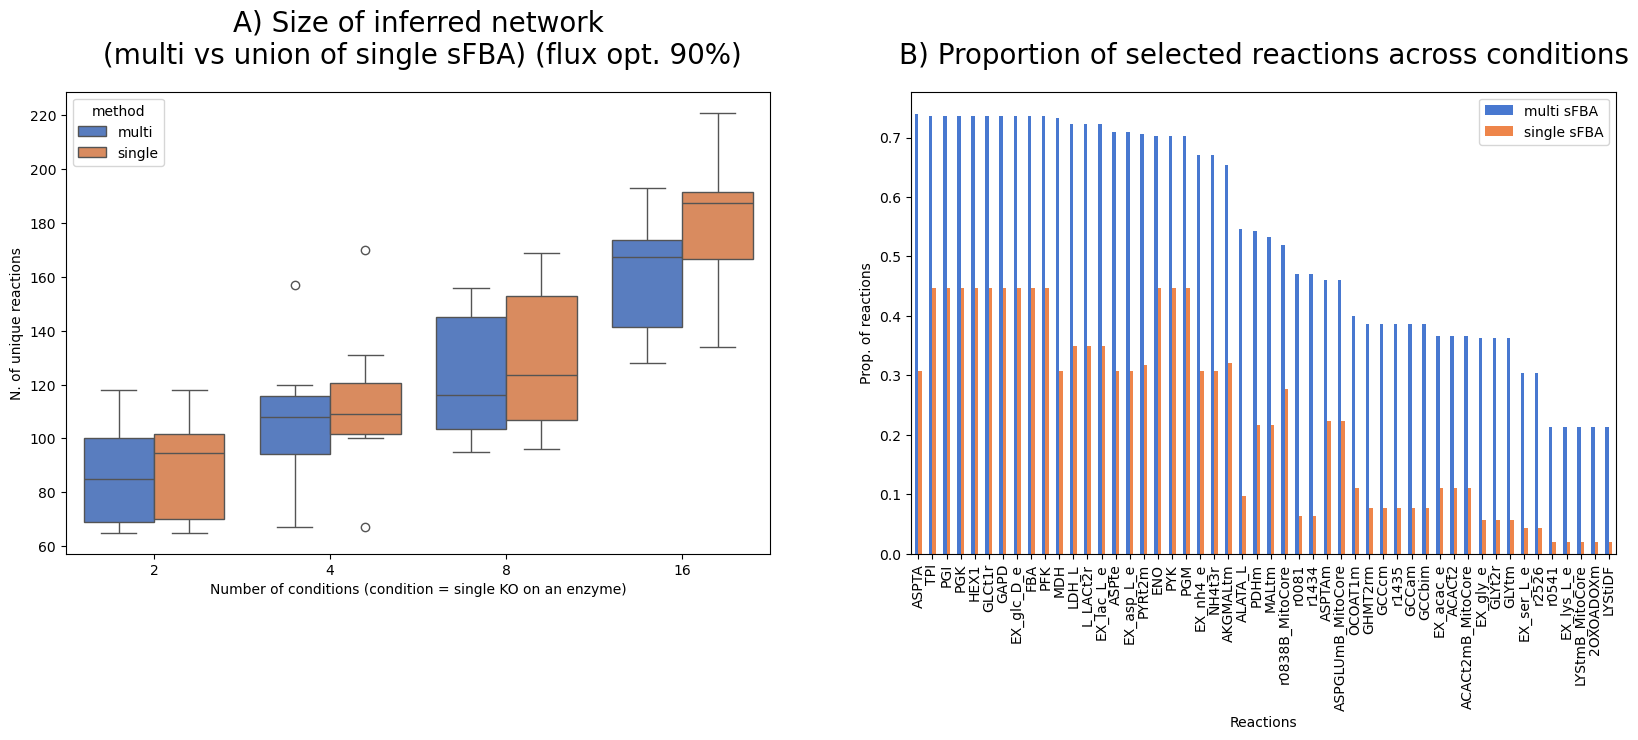

In [25]:
create_multifig(df_experiments, results_90, prop=prop_opt_ko, n_top_rxn_prop=50);

In [26]:
prop_opt_ko=0.10
results_10 = run_experiments(df_experiments, prop_opt_ko=prop_opt_ko)

k=3 (row 0), selected interventions: [171 483]
- Running single...
0 171 4.827050695790599
1 483 1.2916868239866859
- Running multi...
Intervention: 171, FBA sol = 48.27050695790599, FBA sol 10.0% = 4.827050695790599
Intervention: 483, FBA sol = 12.916868239866858, FBA sol 10.0% = 1.2916868239866859
N. conditions = 16, Inferred network size: single=52, multi=47
k=3 (row 1), selected interventions: [485 109]
- Running single...
0 485 9.74018597921465
1 109 0.21026237244533108
- Running multi...
Intervention: 485, FBA sol = 97.40185979214648, FBA sol 10.0% = 9.74018597921465
Intervention: 109, FBA sol = 2.1026237244533106, FBA sol 10.0% = 0.21026237244533108
N. conditions = 16, Inferred network size: single=80, multi=56
k=3 (row 2), selected interventions: [ 81 485]
- Running single...
0 81 9.738249779574097
1 485 9.74018597921465
- Running multi...
Intervention: 81, FBA sol = 97.38249779574096, FBA sol 10.0% = 9.738249779574097
Intervention: 485, FBA sol = 97.40185979214648, FBA sol 10.

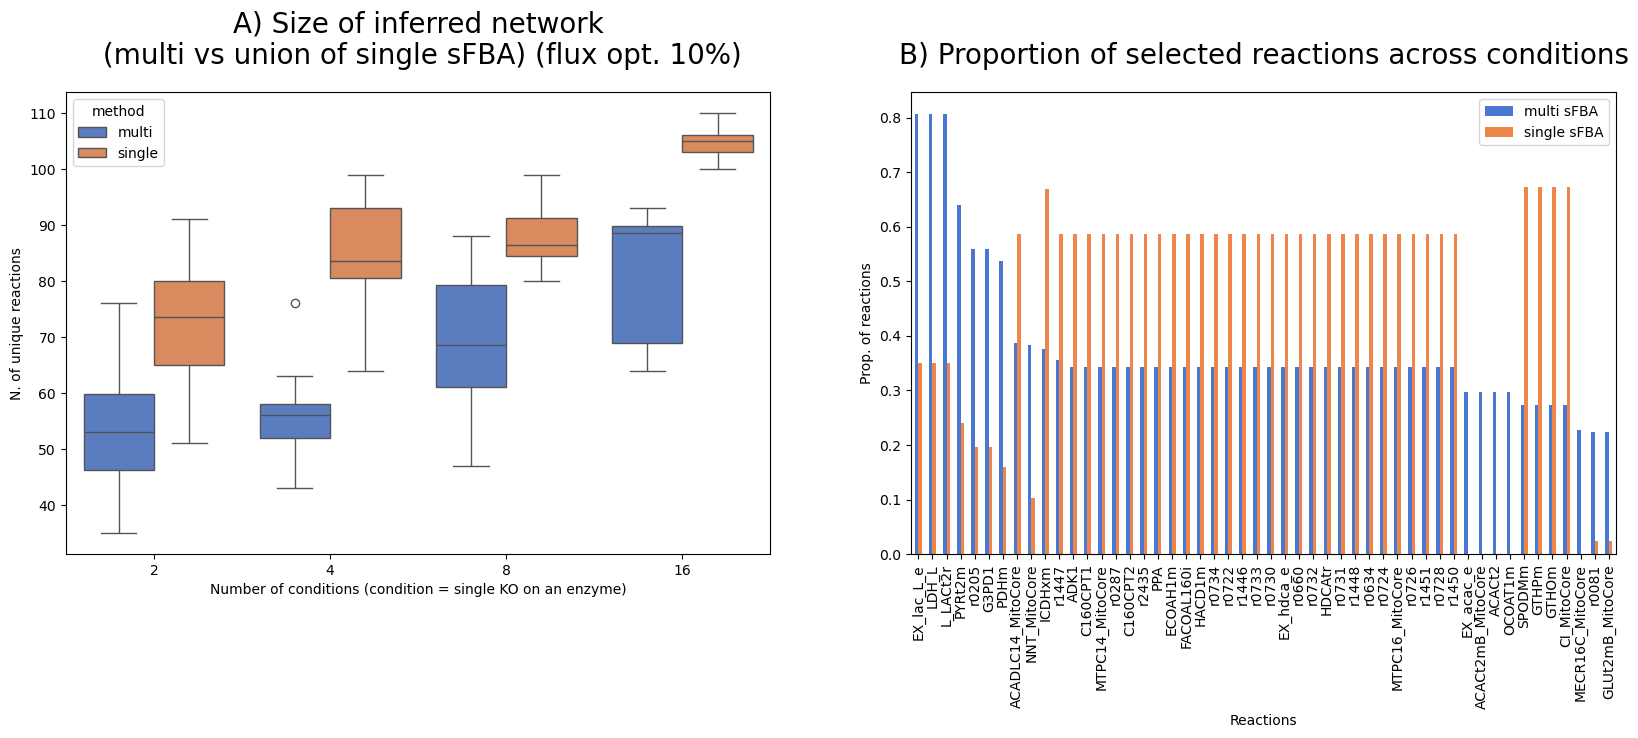

In [27]:
create_multifig(df_experiments, results_10, prop=prop_opt_ko, n_top_rxn_prop=50);

In [28]:
# Average reduction in size
def reduction(results):
    reductions = []
    for r in results:
        M = r[-1]
        S = r[-2]
        reduction = ((S-M)/S)*100
        reductions.append(reduction)
    return np.mean(reductions)

In [29]:
reduction(results_90), reduction(results_10)

(5.890133014688596, 25.013283177868555)

## Additional plots

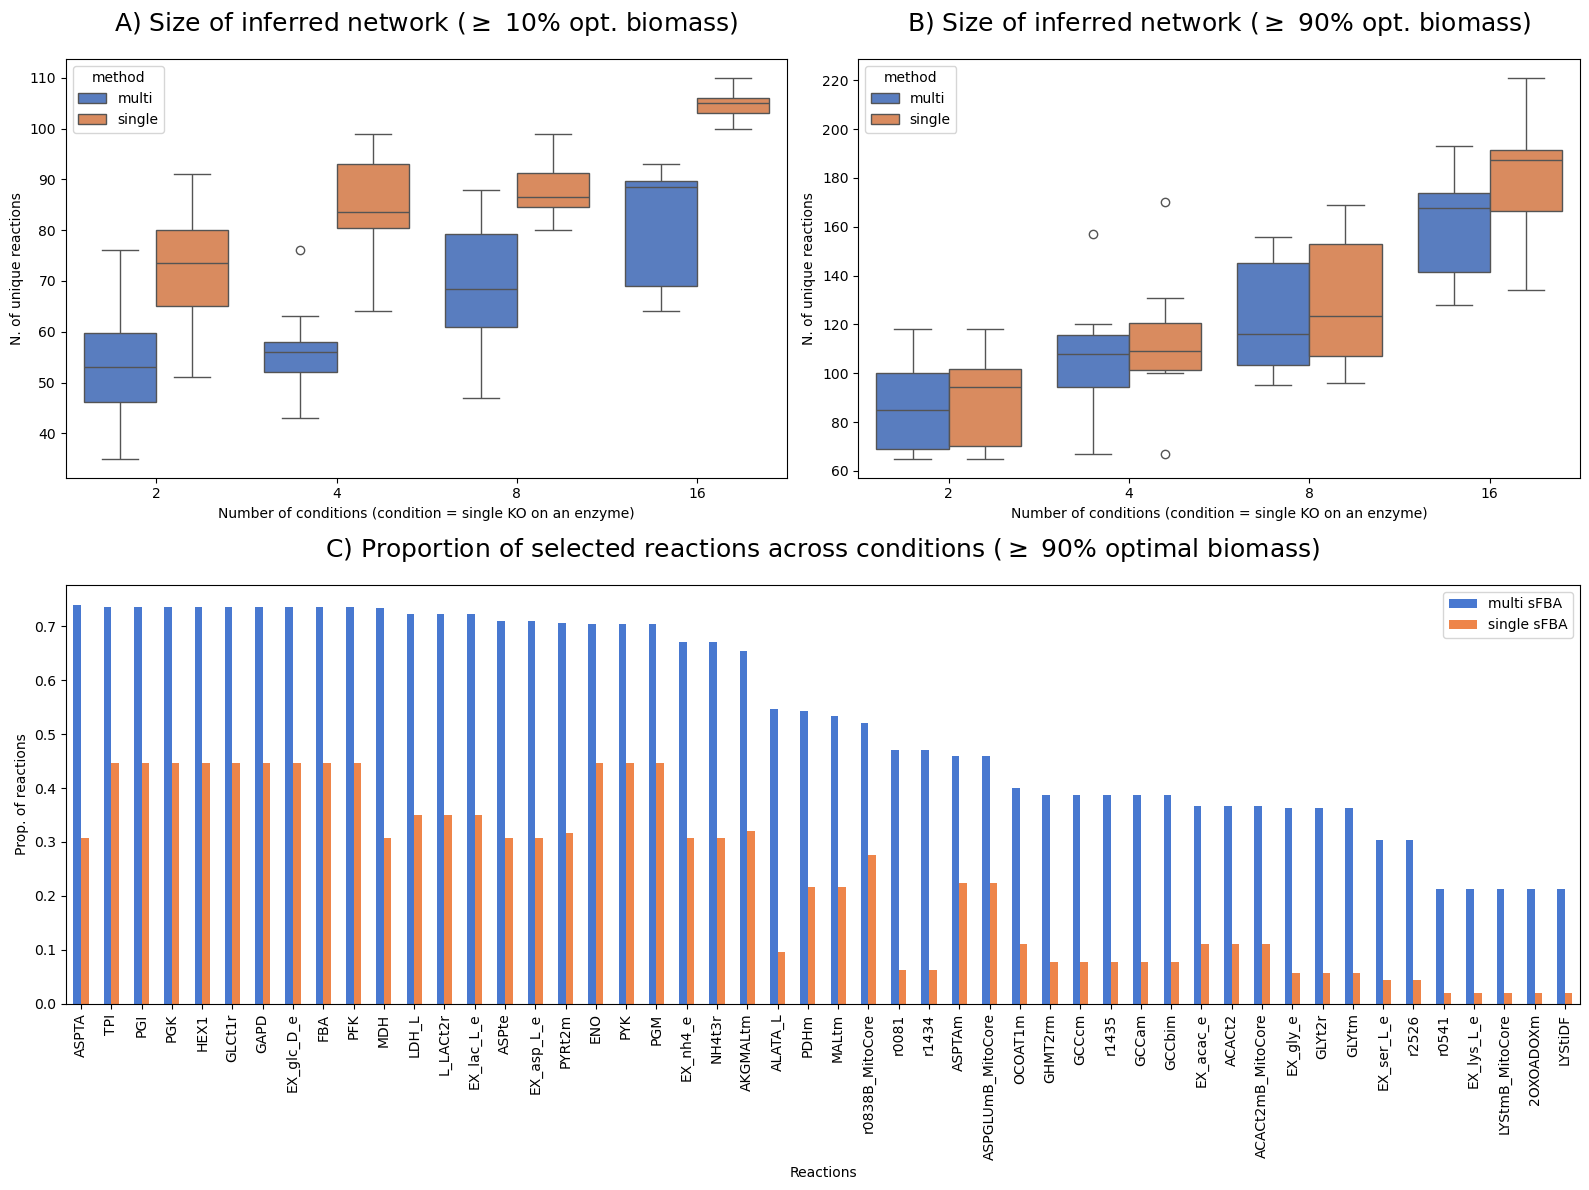

In [30]:
title_size = 18
title_pad = 20

plt.figure(figsize=(16, 12))
ax1 = plt.subplot2grid((2, 2), (0, 0))
boxplots(get_df_results(df_experiments, results_10), ax=ax1)

# Add second subplot in first row, second column
ax2 = plt.subplot2grid((2, 2), (0, 1))
boxplots(get_df_results(df_experiments, results_90), ax=ax2)

# Add third subplot in second row spanning across both columns
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)
plot_rxn_proportions(calc_props(results_90), ax=ax3, n=50);

ax1.set_title("A) Size of inferred network ($\geq$ 10% opt. biomass)", fontsize=title_size, pad=title_pad)
ax2.set_title("B) Size of inferred network ($\geq$ 90% opt. biomass)", fontsize=title_size, pad=title_pad)
ax3.set_title("C) Proportion of selected reactions across conditions ($\geq$ 90% optimal biomass)", fontsize=title_size, pad=title_pad)

# Show the plot
plt.tight_layout()
plt.savefig("single_multi_sfba.pdf", format="pdf")

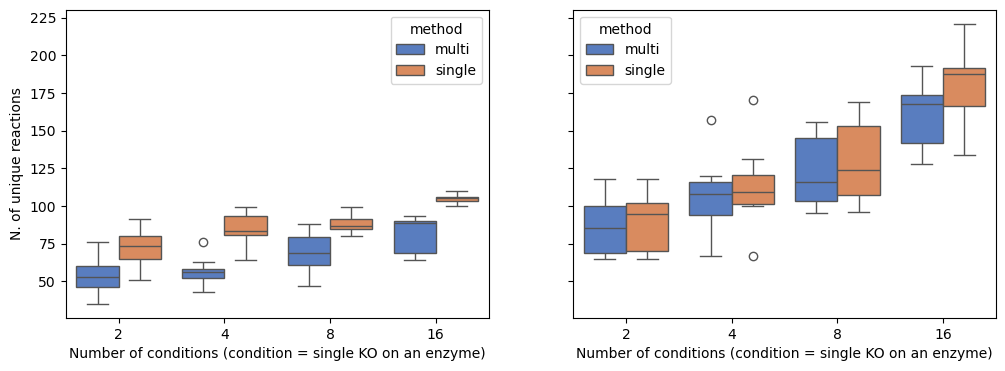

In [31]:
# Export images independently
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
boxplots(get_df_results(df_experiments, results_10), ax=ax[0]);
boxplots(get_df_results(df_experiments, results_90), ax=ax[1]);

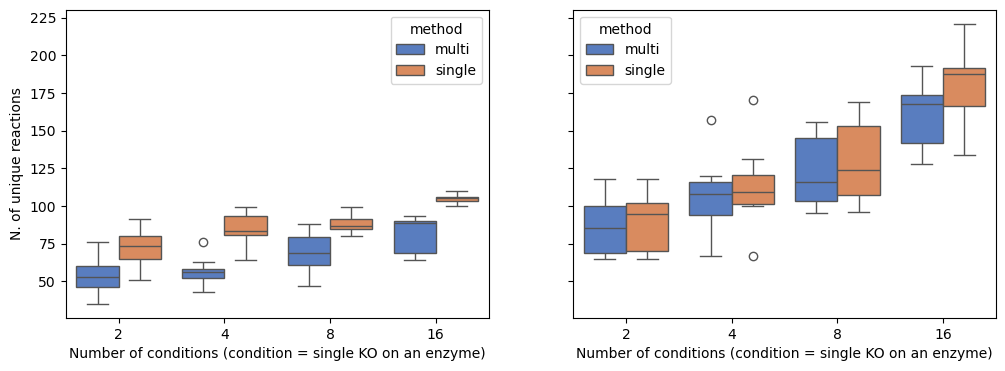

In [32]:
import matplotlib.pyplot as plt

# Original plotting code
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
boxplots(get_df_results(df_experiments, results_10), ax=ax[0])
boxplots(get_df_results(df_experiments, results_90), ax=ax[1])

# Function to redraw and save an axis's plot
def draw_and_save(df, filename, original_ax):
    # Create a new figure and axis
    fig, ax = plt.subplots(figsize=(6, 4))
    
    # Redraw the plot using the same data and styling
    boxplots(df, ax=ax)
    
    # Reapply any additional settings from the original axis
    ax.set_xlim(original_ax.get_xlim())
    ax.set_ylim(original_ax.get_ylim())
    ax.set_xlabel(original_ax.get_xlabel())
    ax.set_ylabel(original_ax.get_ylabel())
    ax.set_title(original_ax.get_title())

    # Save the figure
    fig.savefig(filename)
    plt.close(fig)  # Close the figure to free up memory

# Redraw and save each plot
draw_and_save(get_df_results(df_experiments, results_10), 'results_10.pdf', ax[0])
draw_and_save(get_df_results(df_experiments, results_90), 'results_90.pdf', ax[1])


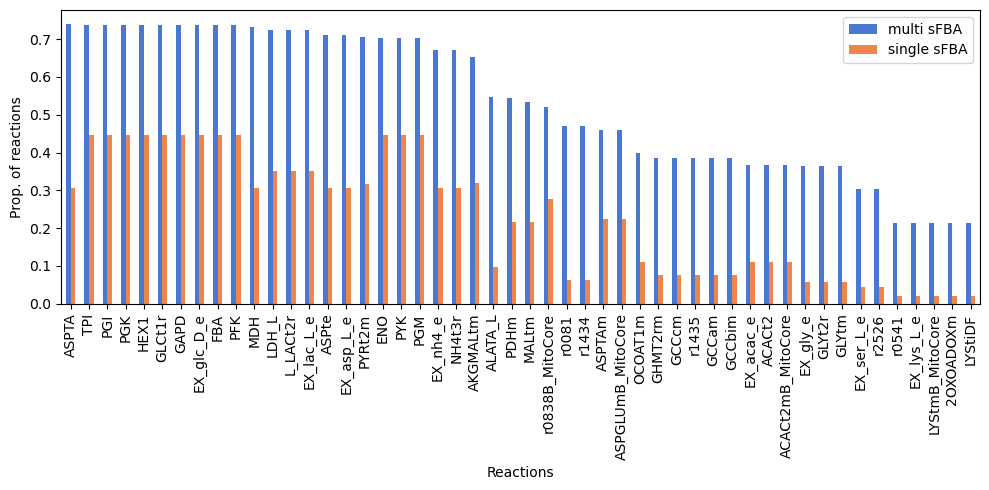

In [33]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_rxn_proportions(calc_props(results_90), ax=ax, n=50);
fig.tight_layout()
fig.savefig("prop_90perc.pdf")
